# Discover Symmetry of Kepler in 2D (Training)

## Import packages

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.integrate import odeint
from functools import partial
import multiprocessing

In [2]:
torch.manual_seed(8407)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 2   # arbitrary default
cpus

12

## Play with Data

* Data: $(x,y,v_x,v_y)$


* Hamiltonian:
    $$H = \frac{p^2}{2m} - \frac{GMm}{r}$$
    

* Hamilton's Equation of motion (assume $m=1$):

    \begin{align}
    \dot{x} &= \partial_{p_x}H = p_x = v_x \\
    \dot{v_x} &= -\partial_x H = -\frac{GM}{r^3}x \\
    \dot{y} &= \partial_{p_y}H = p_y = v_y \\
    \dot{v_y} &= -\partial_y H = -\frac{GM}{r^3}y
    \end{align}

In [5]:
G = 1
M = 1

In [6]:
def eom(z, t):
    x, y, vx, vy = z
    dxdt = vx
    dydt = vy
    dvxdt = - G * M / (x**2 + y**2)**(3/2) * x
    dvydt = - G * M / (x**2 + y**2)**(3/2) * y
    return [dxdt, dydt, dvxdt, dvydt]

In [7]:
z0 = [1, 1, -0.3, 0.3]
print(z0)
t = torch.linspace(0, 5, 1000)

[1, 1, -0.3, 0.3]


In [8]:
z = odeint(eom, z0, t)

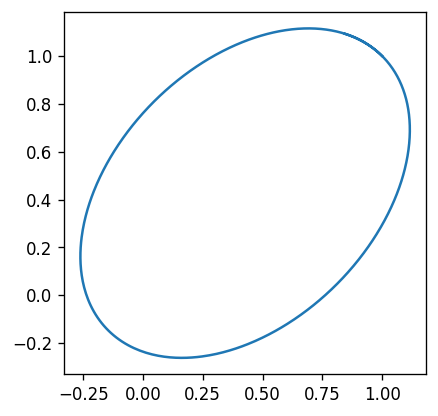

In [9]:
plt.figure(dpi=120)
plt.plot(z[:,0], z[:,1])
ax = plt.gca()
ax.set_aspect("equal")

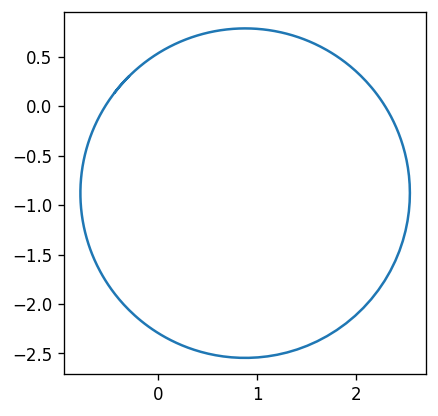

In [10]:
plt.figure(dpi=120)
plt.plot(z[:,2], z[:,3])
ax = plt.gca()
ax.set_aspect("equal")

In [58]:
pool = multiprocessing.pool.ThreadPool(12)
        
t = torch.linspace(0., 10., 100)
u_r = Uniform(1, 2)
u_th = Uniform(0, 2*np.pi)
u_e = Uniform(-0.1,0.1)
u_vx = Uniform(-0.2,-0.1)
u_vy = Uniform(0.1,0.2)
n = 100
r = u_r.sample((n,))
th= u_th.sample((n,))
x = r*torch.cos(th)
y = r*torch.sin(th)
vx = -0.5*y + u_e.sample((n,))
vy = 0.5*x + u_e.sample((n,))
z = torch.column_stack([
    x, 
    y, 
    u_vx.sample((n,)),
    u_vy.sample((n,))
])

def ode_fn(i):
    return torch.Tensor(odeint(eom, z[i,:], t)).float()

sol = pool.map(ode_fn, range(0, n))

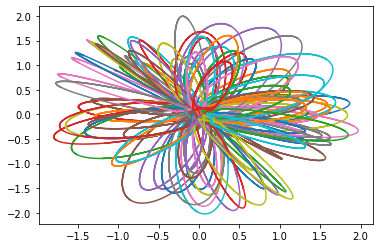

In [59]:
for i in range(n):
    plt.plot(sol[i][:,0], sol[i][:,1])
plt.show()

In [21]:
len(sol)

100

In [22]:
sol_stack = torch.stack(sol, dim=2).permute(0,2,1)

In [23]:
sol_stack.shape

torch.Size([100, 100, 4])

In [24]:
pts = torch.vstack([torch.randperm(100)[:2] for i in range(n)])
X = torch.Tensor(100,4)
X_p = torch.Tensor(100,4)
for i in range(100):
    X[i,:] = sol_stack[i,pts[i,0],:]
    X_p[i,:] = sol_stack[i,pts[i,1],:]
print(X.shape)
print(X_p.shape)

torch.Size([100, 4])
torch.Size([100, 4])


## Implement Dataset

In [60]:
class Kepler2D(Dataset):
    def __init__(self, size, t=(0.,10.,100), G=1, M=1):
        tmin, tmax, tnum = t
        n=size
        
        def eom(z, t):
            x, y, vx, vy = z
            dxdt = vx
            dydt = vy
            dvxdt = - G * M / (x**2 + y**2)**(3/2) * x
            dvydt = - G * M / (x**2 + y**2)**(3/2) * y
            return [dxdt, dydt, dvxdt, dvydt]
        
        t = torch.linspace(tmin, tmax, tnum)
        
        u_r = Uniform(1, 2)
        u_th = Uniform(0, 2*np.pi)
        u_e = Uniform(-0.1,0.1)
        u_vx = Uniform(-0.2,-0.1)
        u_vy = Uniform(0.1,0.2)

        r = u_r.sample((n,))
        th= u_th.sample((n,))
        x = r*torch.cos(th)
        y = r*torch.sin(th)
        vx = -0.5*y + u_e.sample((n,))
        vy = 0.5*x + u_e.sample((n,))
        z = torch.column_stack([
            x,
            y,
            u_vx.sample((n,)),
            u_vy.sample((n,))
        ])

        def ode_fn(i):
            return torch.Tensor(odeint(eom, z[i,:], t)).float()

        sol = pool.map(ode_fn, range(0, n))
        sol = torch.stack(sol, dim=2).permute(0, 2, 1)
        
        # Positive Pair
        pts = torch.vstack([torch.randperm(len(t))[:3] for i in range(n)]) # 각 궤도에서 랜덤으로 점 3개 선택
        X = torch.Tensor(n, 4)
        X_p = torch.Tensor(n, 4)
        X_n = torch.Tensor(n, 4)
        X_n[0,:] = sol[n-1,pts[0,2],:]
        for i in range(n):
            X[i,:] = sol[i,pts[i,0],:]
            X_p[i,:] = sol[i,pts[i,1],:]
            if i > 0:
                X_n[i,:] = sol[i-1,pts[i,2],:]  # Positive pair들의 다음 궤도 선택 (항상 다른 궤도 보장)
        
#         # Negative Pair - 1. x
#         idx_x = torch.randperm(len(t))
#         X_x = X.clone()
#         X_x[:,0] = X_x[idx_x, 0]
        
#         # Negative Pair - 2. y
#         idx_y = torch.randperm(len(t))
#         X_y = X.clone()
#         X_y[:,1] = X_y[idx_y, 1]
        
#         # Negative Pair - 3. vx
#         idx_vx = torch.randperm(len(t))
#         X_vx = X.clone()
#         X_vx[:,2] = X_vx[idx_vx, 2]
        
#         # Negative Pair - 4. vy
#         idx_vy = torch.randperm(len(t))
#         X_vy = X.clone()
#         X_vy[:,3] = X_y[idx_vy, 3]
        
#         # Mix Negative Pair
#         X_n_tot = torch.stack([X_x, X_y, X_vx, X_vy], dim=2)
#         idx_neg = torch.randint(4, (len(t),))
#         X_n = torch.Tensor(X.shape[0], X.shape[1])
#         for i in range(X.shape[0]):
#             X_n[i, :] = X_n_tot[i, :, idx_neg[i]]
            
        # Mix Pairs with label
        self.X = torch.vstack([X, X])
        self.X_pair = torch.vstack([X_p, X_n])
        
        # Labelling
        y_p = torch.zeros((X_p.shape[0], 1))
        y_n = torch.ones((X_n.shape[0], 1))
        self.y = torch.vstack([y_p, y_n])
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = torch.Tensor(self.X[idx])
        x_pair = torch.Tensor(self.X_pair[idx])
        y = torch.Tensor(self.y[idx])
        return x, x_pair, y

In [53]:
# t_train = (0, 10, 100)
# t_valid = (0, 10, 100)

In [62]:
train_dataset = Kepler2D(10000)
valid_dataset = Kepler2D(5000)

train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=500)

dataloaders_dict = {
    "train": train_dataloader,
    "val": valid_dataloader
}

IndexError: index 9999 is out of bounds for dimension 0 with size 100

In [19]:
for _, samples in enumerate(train_dataloader):
    x, x_p, y = samples
    temp = torch.column_stack([x, x_p, y])
    print(temp[:5, :])
    break

tensor([[ 0.8915,  1.0749, -0.4043,  0.1855,  0.8915,  1.0749, -0.4043,  0.3154,
          1.0000],
        [ 0.5209, -0.1664,  1.3858,  0.7091,  0.7948,  1.1059, -0.4749,  0.0942,
          0.0000],
        [ 1.1112,  0.7624, -0.0644,  0.4958, -0.0938,  0.6424, -0.7707, -1.1192,
          0.0000],
        [ 0.8850,  1.0779, -0.4096,  0.1791,  1.1146,  0.6577,  0.0316,  0.5569,
          0.0000],
        [ 1.0169,  0.3261,  0.3696,  0.7085,  1.0551,  0.4083,  0.2770,  0.6758,
          0.0000]])


## Implement Siamese Network

In [20]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.linear_relu = nn.Sequential(
            nn.Linear(4,100),
            nn.ReLU(),
            nn.Linear(100,1),
            nn.LeakyReLU()
        )

    def forward(self, x1, x2):
        out1 = self.linear_relu(x1)
        out2 = self.linear_relu(x2)
        return out1, out2

In [21]:
net = SNN()
print(net)

SNN(
  (linear_relu): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
)


## Implement Contrastive Loss (Hadsell)

In [22]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [23]:
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

In [24]:
def train(net, dataloaders_dict, criterion, optimizer, num_epochs, dist=1):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("----------------------")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corr = 0
            
            data = dataloaders_dict[phase]
            for batch, samples in enumerate(tqdm(data)):
                X, X_p, y = samples
                X, X_p, y = X.to(device), X_p.to(device), y.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=="train"):
                    out1, out2 = net(X, X_p)
                    loss = criterion(out1, out2, y)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() + X.shape[0]
                    epoch_corr += torch.count_nonzero((torch.abs(out1 - out2) <= dist) != y).item()
                    
            epoch_loss = epoch_loss / len(data.dataset)
            epoch_acc = epoch_corr / len(data.dataset)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)
                scheduler.step(epoch_loss)
                lr = scheduler._last_lr[0]
                print(f" Validation Loss: {epoch_loss:>8f}")
                print(f" Validation Acc : {epoch_acc:>8f}")
                print(f" Learning Rate  : {lr:>8f}\n")
                if lr < 1e-6:
                    return train_loss, val_loss
            
    return train_loss, val_loss

In [25]:
train_loss, val_loss = train(net, dataloaders_dict, criterion, optimizer, 500, 0.2)

  8%|▊         | 15/200 [00:00<00:01, 146.75it/s]

Epoch 1/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 143.37it/s]

 Validation Loss: 1.000264
 Validation Acc : 0.989100
 Learning Rate  : 0.010000

Epoch 2/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 213.32it/s]

 Validation Loss: 1.000193
 Validation Acc : 0.991100
 Learning Rate  : 0.010000

Epoch 3/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 212.62it/s]

 Validation Loss: 1.000166
 Validation Acc : 0.969100
 Learning Rate  : 0.010000

Epoch 4/500
----------------------


 10%|█         | 21/200 [00:00<00:00, 205.00it/s]

 Validation Loss: 1.000149
 Validation Acc : 0.970300
 Learning Rate  : 0.010000

Epoch 5/500
----------------------


 10%|█         | 21/200 [00:00<00:00, 204.74it/s]

 Validation Loss: 1.000146
 Validation Acc : 0.903900
 Learning Rate  : 0.010000

Epoch 6/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 211.41it/s]

 Validation Loss: 1.000120
 Validation Acc : 0.994100
 Learning Rate  : 0.010000

Epoch 7/500
----------------------


 10%|█         | 21/200 [00:00<00:00, 205.55it/s]

 Validation Loss: 1.000115
 Validation Acc : 0.994200
 Learning Rate  : 0.010000

Epoch 8/500
----------------------


 10%|▉         | 19/200 [00:00<00:00, 183.85it/s]

 Validation Loss: 1.000109
 Validation Acc : 0.994300
 Learning Rate  : 0.001000

Epoch 9/500
----------------------


  8%|▊         | 15/200 [00:00<00:01, 149.00it/s]

 Validation Loss: 1.000108
 Validation Acc : 0.994300
 Learning Rate  : 0.001000

Epoch 10/500
----------------------


  8%|▊         | 16/200 [00:00<00:01, 152.35it/s]

 Validation Loss: 1.000107
 Validation Acc : 0.994500
 Learning Rate  : 0.001000

Epoch 11/500
----------------------


 10%|▉         | 19/200 [00:00<00:00, 182.33it/s]

 Validation Loss: 1.000106
 Validation Acc : 0.994500
 Learning Rate  : 0.001000

Epoch 12/500
----------------------


 10%|▉         | 19/200 [00:00<00:00, 181.45it/s]

 Validation Loss: 1.000106
 Validation Acc : 0.994700
 Learning Rate  : 0.000100

Epoch 13/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 169.45it/s]

 Validation Loss: 1.000105
 Validation Acc : 0.994700
 Learning Rate  : 0.000100

Epoch 14/500
----------------------


  7%|▋         | 14/200 [00:00<00:01, 137.42it/s]

 Validation Loss: 1.000105
 Validation Acc : 0.994700
 Learning Rate  : 0.000100

Epoch 15/500
----------------------


  8%|▊         | 15/200 [00:00<00:01, 140.55it/s]

 Validation Loss: 1.000105
 Validation Acc : 0.994700
 Learning Rate  : 0.000100

Epoch 16/500
----------------------


 10%|▉         | 19/200 [00:00<00:00, 187.83it/s]

 Validation Loss: 1.000105
 Validation Acc : 0.994700
 Learning Rate  : 0.000010

Epoch 17/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 179.17it/s]

 Validation Loss: 1.000105
 Validation Acc : 0.994700
 Learning Rate  : 0.000010

Epoch 18/500
----------------------


 10%|▉         | 19/200 [00:00<00:00, 186.44it/s]

 Validation Loss: 1.000105
 Validation Acc : 0.994700
 Learning Rate  : 0.000010

Epoch 19/500
----------------------


 10%|▉         | 19/200 [00:00<00:00, 187.03it/s]

 Validation Loss: 1.000105
 Validation Acc : 0.994700
 Learning Rate  : 0.000010

Epoch 20/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 166.44it/s]

 Validation Loss: 1.000105
 Validation Acc : 0.994700
 Learning Rate  : 0.000001

Epoch 21/500
----------------------


 10%|█         | 20/200 [00:00<00:00, 199.79it/s]

 Validation Loss: 1.000105
 Validation Acc : 0.994700
 Learning Rate  : 0.000001

Epoch 22/500
----------------------


 10%|▉         | 19/200 [00:00<00:00, 184.37it/s]

 Validation Loss: 1.000105
 Validation Acc : 0.994700
 Learning Rate  : 0.000001

Epoch 23/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 167.87it/s]

 Validation Loss: 1.000105
 Validation Acc : 0.994700
 Learning Rate  : 0.000001

Epoch 24/500
----------------------


100%|██████████| 20/20 [00:00<00:00, 200.74it/s]

 Validation Loss: 1.000105
 Validation Acc : 0.994700
 Learning Rate  : 0.000000



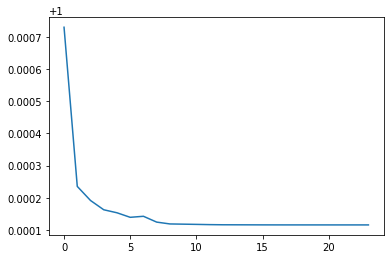

In [26]:
plt.plot(train_loss)
plt.show()

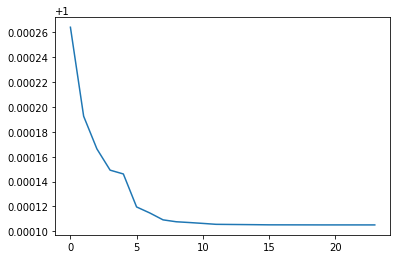

In [27]:
plt.plot(val_loss)
plt.show()

In [28]:
anc1, pos, ans1 = train_dataset[0:10]
anc2, neg, ans2 = train_dataset[-10:]

In [29]:
with torch.no_grad():
    a, b = net(anc1, pos)
    res1 = torch.column_stack([a, b])
    print(res1)

tensor([[4.3803, 4.3431],
        [4.3803, 4.3705],
        [4.3804, 4.3674],
        [4.3804, 4.3817],
        [4.3805, 4.3734],
        [4.3805, 4.3711],
        [4.3806, 4.3744],
        [4.3806, 4.3705],
        [4.3807, 4.3589],
        [4.3807, 4.3676]])


In [30]:
with torch.no_grad():
    c, d = net(anc2, neg)
    res2 = torch.column_stack([c, d])
    print(res2)

tensor([[ 4.3765, 48.6590],
        [ 4.3766,  2.7539],
        [ 4.3767, 39.2207],
        [ 4.3767, 28.2110],
        [ 4.3768, 19.5533],
        [ 4.3769,  3.9626],
        [ 4.3770, -0.2251],
        [ 4.3770, -0.0620],
        [ 4.3771,  5.3240],
        [ 4.3772, 14.6025]])


In [31]:
torch.save(net, "model/snn_kepl2d_03.pt")